In [1]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm.auto import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0) 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-12 06:40:17.087643: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path1 = './IDRID/Original_Images/Training_Set'
# training masks directory
path2 = './IDRID/All_Segmentation_Groundtruths/Training_Set/Haemorrhages'
patch_size = 512

In [3]:
image_dataset = []
images = sorted(os.listdir(path1)) 
for i, image_name in tqdm(enumerate(images), total=len(images)):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path1+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 

       image = (image.astype('float32')) / 255.                    
       image_dataset.append(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.18it/s]


In [4]:
len(image_dataset)

54

In [5]:
mask_dataset = []
images = sorted(os.listdir(path2)) 

for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.endswith(".tif"):
        image = skimage.io.imread(path2 + "/" + image_name)  # Read image

        if image.ndim == 3:  # RGB image
            image = image[:, :, 1]  # Select green channel

        image = Image.fromarray(image)
        image = image.resize((512, 512))  # Resize image to 512x512
        image = np.array(image, dtype=np.float32)  # Convert to float32 and normalize

        mask_dataset.append(image)
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 20.54it/s]


In [6]:
len(mask_dataset)

54

In [7]:
print(mask_dataset[0].shape)

(512, 512, 1)


In [8]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [9]:
IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [10]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv
def inverted_residual_block(x, expand=64, squeeze=16, dropout=0, batchnorm=False):
    m = layers.Conv2D(expand, (1, 1), activation='relu')(x)
    if batchnorm is True:
        m = layers.BatchNormalization(axis=3)(m)
    m = layers.DepthwiseConv2D((3, 3), activation='relu', padding='same')(m)
    if batchnorm is True:
        m = layers.BatchNormalization(axis=3)(m)
    m = layers.Conv2D(squeeze, (1, 1), activation='relu')(m)
    if dropout > 0:
        m = layers.Dropout(dropout)(m)
    if x.shape[-1] != squeeze:
        x = layers.Conv2D(squeeze, (1, 1), activation='relu')(x)
    respath = layers.add([m, x])
    return respath

#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)    
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)
        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])       
    return respath

#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock


def receptive_field_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    # Receptive field block
    pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    receptive_field = conv_block(pool, kernelsize, filters, dropout, batchnorm)
    upsampled_receptive_field = layers.UpSampling2D(size=(2, 2))(receptive_field)
    conv = layers.concatenate([conv, upsampled_receptive_field], axis=3)
    
    return conv


def unetmodel_residual(input_shape, dropout=0.2, batchnorm=True):
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers with receptive field blocks
    dn_1 = receptive_field_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = receptive_field_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = receptive_field_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = receptive_field_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = receptive_field_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), interpolation='bilinear')(dn_5)
    up_conv_5 = inverted_residual_block(up_5, expand=filters[3], squeeze=filters[3], dropout=dropout, batchnorm=batchnorm)
    up_5 = layers.concatenate([up_conv_5, dn_4], axis=3)
    up_5 = layers.Conv2D(filters[0], (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(up_5)

    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_5)
    up_conv_4 = inverted_residual_block(up_4, expand=filters[2], squeeze=filters[2], dropout=dropout, batchnorm=batchnorm)
    up_4 = layers.concatenate([up_conv_4,dn_3], axis=3)
    up_4 = layers.Conv2D(filters[1], (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(up_4)

    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_4)
    up_conv_3 = inverted_residual_block(up_3, expand=filters[1], squeeze=filters[1], dropout=dropout, batchnorm=batchnorm)
    up_3 = layers.concatenate([up_conv_3,dn_2], axis=3)
    up_3 = layers.Conv2D(filters[2], (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(up_3)

    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_3)
    up_conv_2 = inverted_residual_block(up_2, expand=filters[0], squeeze=filters[0], dropout=dropout, batchnorm=batchnorm)
    up_2 = layers.concatenate([up_conv_2, dn_1], axis=3)
    up_2 = layers.Conv2D(filters[3], (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(up_2)

    conv_final = layers.Conv2D(1, kernel_size=(1, 1), padding='same')(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model


In [2]:
from keras import backend as K
import tensorflow as tf
defined_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='mean_iou'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='dice_score'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='f1_score'),
]

In [12]:
model = unetmodel_residual(input_shape)
model.compile(optimizer = Adam(lr = 1e-3), loss= 'binary_crossentropy', metrics=defined_metrics)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 32  9248        ['max_pooling2d_2[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 128, 32  128        ['conv2d_6[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_6 (Activation)      (None, 128, 128, 32  0           ['batch_normalization_6[0][0]']  
                                )                                                                 
                                                                                                  
 dropout_3

 activation_12 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 dropout_6 (Dropout)            (None, 64, 64, 128)  0           ['activation_12[0][0]']          
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 128)  147584      ['dropout_6[0][0]']              
                                                                                                  
 batch_normalization_13 (BatchN  (None, 64, 64, 128)  512        ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_13[0][0]'] 
          

 v2D)                                                                                             
                                                                                                  
 batch_normalization_21 (BatchN  (None, 64, 64, 128)  512        ['depthwise_conv2d[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv2d_21 (Conv2D)             (None, 64, 64, 128)  16512       ['batch_normalization_21[0][0]'] 
                                                                                                  
 dropout_10 (Dropout)           (None, 64, 64, 128)  0           ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 128)  65664       ['up_sampling2d_5[0][0]']        
          

 conv2d_33 (Conv2D)             (None, 512, 512, 16  272         ['batch_normalization_27[0][0]'] 
                                )                                                                 
                                                                                                  
 dropout_13 (Dropout)           (None, 512, 512, 16  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 512, 512, 16  528         ['up_sampling2d_8[0][0]']        
                                )                                                                 
                                                                                                  
 add_3 (Add)                    (None, 512, 512, 16  0           ['dropout_13[0][0]',             
          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.3, random_state=0)

In [15]:
history = model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 1,
                    validation_data=(x_test, y_test ), 
                    shuffle=False,
                    epochs=200,
                    )

Epoch 1/200
37/37 [==============================] - 1s 34ms/step - loss: 0.6646 - auc: 0.5389 - accuracy: 0.6607 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.8359 - val_auc: 0.4637 - val_accuracy: 0.0108 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 2/200
37/37 [==============================] - 2s 41ms/step - loss: 0.6382 - auc: 0.5463 - accuracy: 0.8879 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.7936 - val_auc: 0.4942 - val_accuracy: 0.0104 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 3/200
37/37 [==============================] - 2s 49ms/step - loss: 0.6227 - auc: 0.5637 - accuracy: 0.9426 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.7547 - val_auc: 0.5029 - val_accuracy: 0.0104 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 4/200
37/37 [==============================] - 2s 48ms/step - loss: 0.6088 - auc: 

Epoch 28/200
37/37 [==============================] - 2s 58ms/step - loss: 0.3364 - auc: 0.7443 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.3506 - val_auc: 0.4426 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 29/200
37/37 [==============================] - 1s 38ms/step - loss: 0.3290 - auc: 0.7417 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.3431 - val_auc: 0.4435 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 30/200
37/37 [==============================] - 1s 37ms/step - loss: 0.3217 - auc: 0.7460 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.3363 - val_auc: 0.4560 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 31/200
37/37 [==============================] - 2s 44ms/step - loss: 0.3147 - a

Epoch 55/200
37/37 [==============================] - 1s 38ms/step - loss: 0.1951 - auc: 0.6636 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1965 - val_auc: 0.5156 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 56/200
37/37 [==============================] - 1s 37ms/step - loss: 0.1915 - auc: 0.6894 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1934 - val_auc: 0.5610 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 57/200
37/37 [==============================] - 2s 41ms/step - loss: 0.1882 - auc: 0.6873 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1918 - val_auc: 0.5472 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 58/200
37/37 [==============================] - 2s 54ms/step - loss: 0.1848 - a

Epoch 82/200
37/37 [==============================] - 2s 54ms/step - loss: 0.1266 - auc: 0.7801 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1688 - val_auc: 0.4717 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 83/200
37/37 [==============================] - 1s 40ms/step - loss: 0.1247 - auc: 0.7826 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1493 - val_auc: 0.3713 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 84/200
37/37 [==============================] - 1s 37ms/step - loss: 0.1236 - auc: 0.7307 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1500 - val_auc: 0.4138 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 85/200
37/37 [==============================] - 1s 32ms/step - loss: 0.1213 - a

Epoch 109/200
37/37 [==============================] - 1s 40ms/step - loss: 0.0888 - auc: 0.8130 - accuracy: 0.9905 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.3447 - val_auc: 0.3689 - val_accuracy: 0.8488 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 110/200
37/37 [==============================] - 1s 36ms/step - loss: 0.0879 - auc: 0.8238 - accuracy: 0.9901 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1738 - val_auc: 0.3397 - val_accuracy: 0.9755 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 111/200
37/37 [==============================] - 1s 31ms/step - loss: 0.0864 - auc: 0.8331 - accuracy: 0.9904 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.3027 - val_auc: 0.3604 - val_accuracy: 0.9071 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 112/200
37/37 [==============================] - 2s 47ms/step - loss: 0.0850

Epoch 136/200
37/37 [==============================] - 2s 43ms/step - loss: 0.0666 - auc: 0.8503 - accuracy: 0.9909 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.2981 - val_auc: 0.5044 - val_accuracy: 0.9012 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 137/200
37/37 [==============================] - 2s 45ms/step - loss: 0.0642 - auc: 0.8582 - accuracy: 0.9909 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.2052 - val_auc: 0.4017 - val_accuracy: 0.9169 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 138/200
37/37 [==============================] - 1s 39ms/step - loss: 0.0627 - auc: 0.8553 - accuracy: 0.9910 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.2410 - val_auc: 0.3887 - val_accuracy: 0.8910 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 139/200
37/37 [==============================] - 1s 36ms/step - loss: 0.0623

Epoch 163/200
37/37 [==============================] - 2s 48ms/step - loss: 0.0511 - auc: 0.8895 - accuracy: 0.9912 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1005 - val_auc: 0.3743 - val_accuracy: 0.9797 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 164/200
37/37 [==============================] - 1s 40ms/step - loss: 0.0497 - auc: 0.8965 - accuracy: 0.9914 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.1162 - val_auc: 0.4015 - val_accuracy: 0.9724 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 165/200
37/37 [==============================] - 1s 36ms/step - loss: 0.0492 - auc: 0.8974 - accuracy: 0.9914 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.0997 - val_auc: 0.3850 - val_accuracy: 0.9774 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 166/200
37/37 [==============================] - 2s 50ms/step - loss: 0.0487

Epoch 190/200
37/37 [==============================] - 1s 34ms/step - loss: 0.0450 - auc: 0.8934 - accuracy: 0.9910 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.0680 - val_auc: 0.6173 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 191/200
37/37 [==============================] - 1s 33ms/step - loss: 0.0489 - auc: 0.8815 - accuracy: 0.9907 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.0876 - val_auc: 0.5824 - val_accuracy: 0.9890 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 192/200
37/37 [==============================] - 1s 34ms/step - loss: 0.0463 - auc: 0.8883 - accuracy: 0.9907 - mean_iou: 0.4952 - dice_score: 0.4952 - f1_score: 0.4952 - val_loss: 0.0710 - val_auc: 0.6191 - val_accuracy: 0.9896 - val_mean_iou: 0.4948 - val_dice_score: 0.4948 - val_f1_score: 0.4948
Epoch 193/200
37/37 [==============================] - 1s 37ms/step - loss: 0.0450

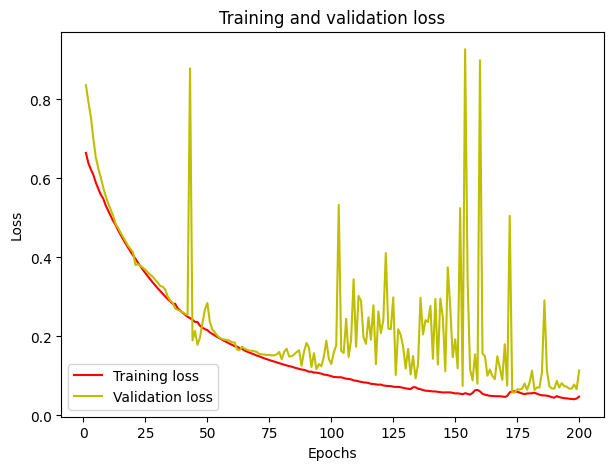

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

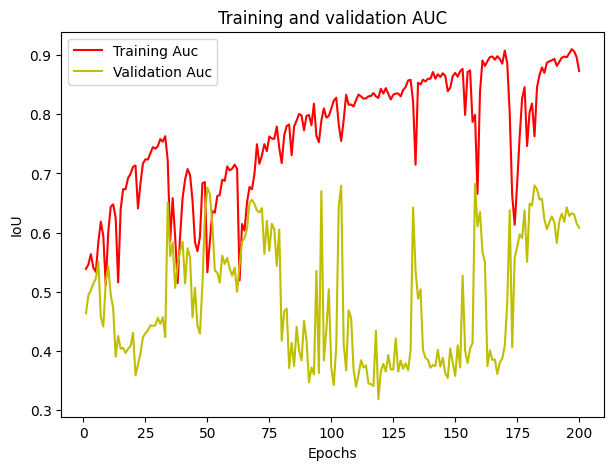

In [17]:
auc = history.history['auc']
val_auc = history.history['val_auc']
plt.figure(figsize=(7,5))
plt.plot(epochs, auc, 'r', label='Training Auc')
plt.plot(epochs, val_auc, 'y', label='Validation Auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [18]:
model.save('./HE_models/Haemorrhages_unetmodel_ive.h5')

In [4]:
model = tf.keras.models.load_model(
    '/Users/karanchaudhary/Downloads/Internship/3. Leison segmentation on IDRID dataset/My Implementation/IDRID segmentation/my Implementation/model weights/Haemorrhages_modifiedU-Net_ive.h5')


ValueError: bad marshal data (unknown type code)

In [20]:
# test dataset images directory path
path3 = './IDRID/Original_Images/Testing_Set'
# test dataset mask directory path
path4 = './IDRID/All_Segmentation_Groundtruths/Testing_Set/Haemorrhages'

In [21]:
testimages = sorted(os.listdir(path3))
testmasks =  sorted(os.listdir(path4))

In [22]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm.auto import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0)

image_dataset = []
images = sorted(os.listdir(path3)) 
for i, image_name in tqdm(enumerate(images), total=len(images)):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path3+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
#        image = clahe_equalized(image) #applying CLAHE
#        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
#        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 
#        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.                    
       image_dataset.append(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:08<00:00,  3.06it/s]


In [23]:
mask_dataset = []
images = sorted(os.listdir(path4)) 

for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.endswith(".tif"):
        image = skimage.io.imread(path4 + "/" + image_name)  # Read image

        if image.ndim == 3:  # RGB image
            image = image[:, :, 1]  # Select green channel
        # else:  # Grayscale or single-channel image, no need to select channel

        image = Image.fromarray(image)
        image = image.resize((512, 512))  # Resize image to 512x512
        image = np.array(image, dtype=np.float32)  # Convert to float32 and normalize

        mask_dataset.append(image)
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
test_image_dataset = np.expand_dims(image_dataset,axis=-1)
test_mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 16.34it/s]


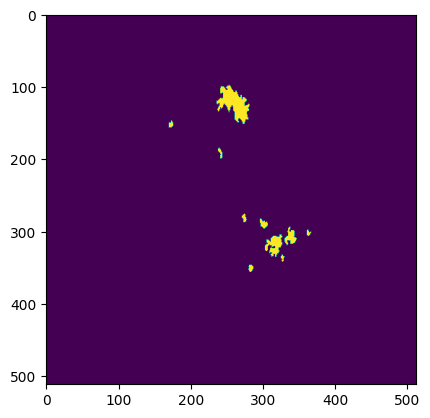

In [24]:
plt.imshow(test_mask_dataset[0])

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_image_dataset, test_mask_dataset, batch_size=1)
print("test loss, test auc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_image_dataset[:1])
print("predictions shape:", predictions.shape)

Evaluate on test data
27/27 [==============================] - 2s 16ms/step - loss: 0.1031 - auc: 0.6124 - accuracy: 0.9822 - mean_iou: 0.4947 - dice_score: 0.4947 - f1_score: 0.4947
test loss, test auc: [0.10306067764759064, 0.6124016046524048, 0.9821808338165283, 0.4946722686290741, 0.4946722686290741, 0.4946722686290741]
Generate predictions for 3 samples
1/1 [==============================] - 1s 974ms/step
predictions shape: (1, 512, 512, 1)


In [26]:
val_pred = model.predict(test_image_dataset, batch_size=1)

27/27 [==============================] - 0s 9ms/step


In [27]:
val_pred  

array([[[[0.0208565 ],
         [0.02145078],
         [0.0226916 ],
         ...,
         [0.01963778],
         [0.01778028],
         [0.01691705]],

        [[0.02054289],
         [0.02106325],
         [0.02214509],
         ...,
         [0.01910646],
         [0.01743013],
         [0.01664728]],

        [[0.0199376 ],
         [0.02031698],
         [0.02109909],
         ...,
         [0.01809324],
         [0.01675698],
         [0.01612596]],

        ...,

        [[0.02091305],
         [0.0207964 ],
         [0.020567  ],
         ...,
         [0.02573465],
         [0.0246329 ],
         [0.02409976]],

        [[0.01782055],
         [0.01764387],
         [0.01729733],
         ...,
         [0.02202952],
         [0.02134227],
         [0.02100687]],

        [[0.01644888],
         [0.01624821],
         [0.01585933],
         ...,
         [0.02037735],
         [0.0198618 ],
         [0.01960932]]],


       [[[0.02041349],
         [0.02099427],
         [0.02

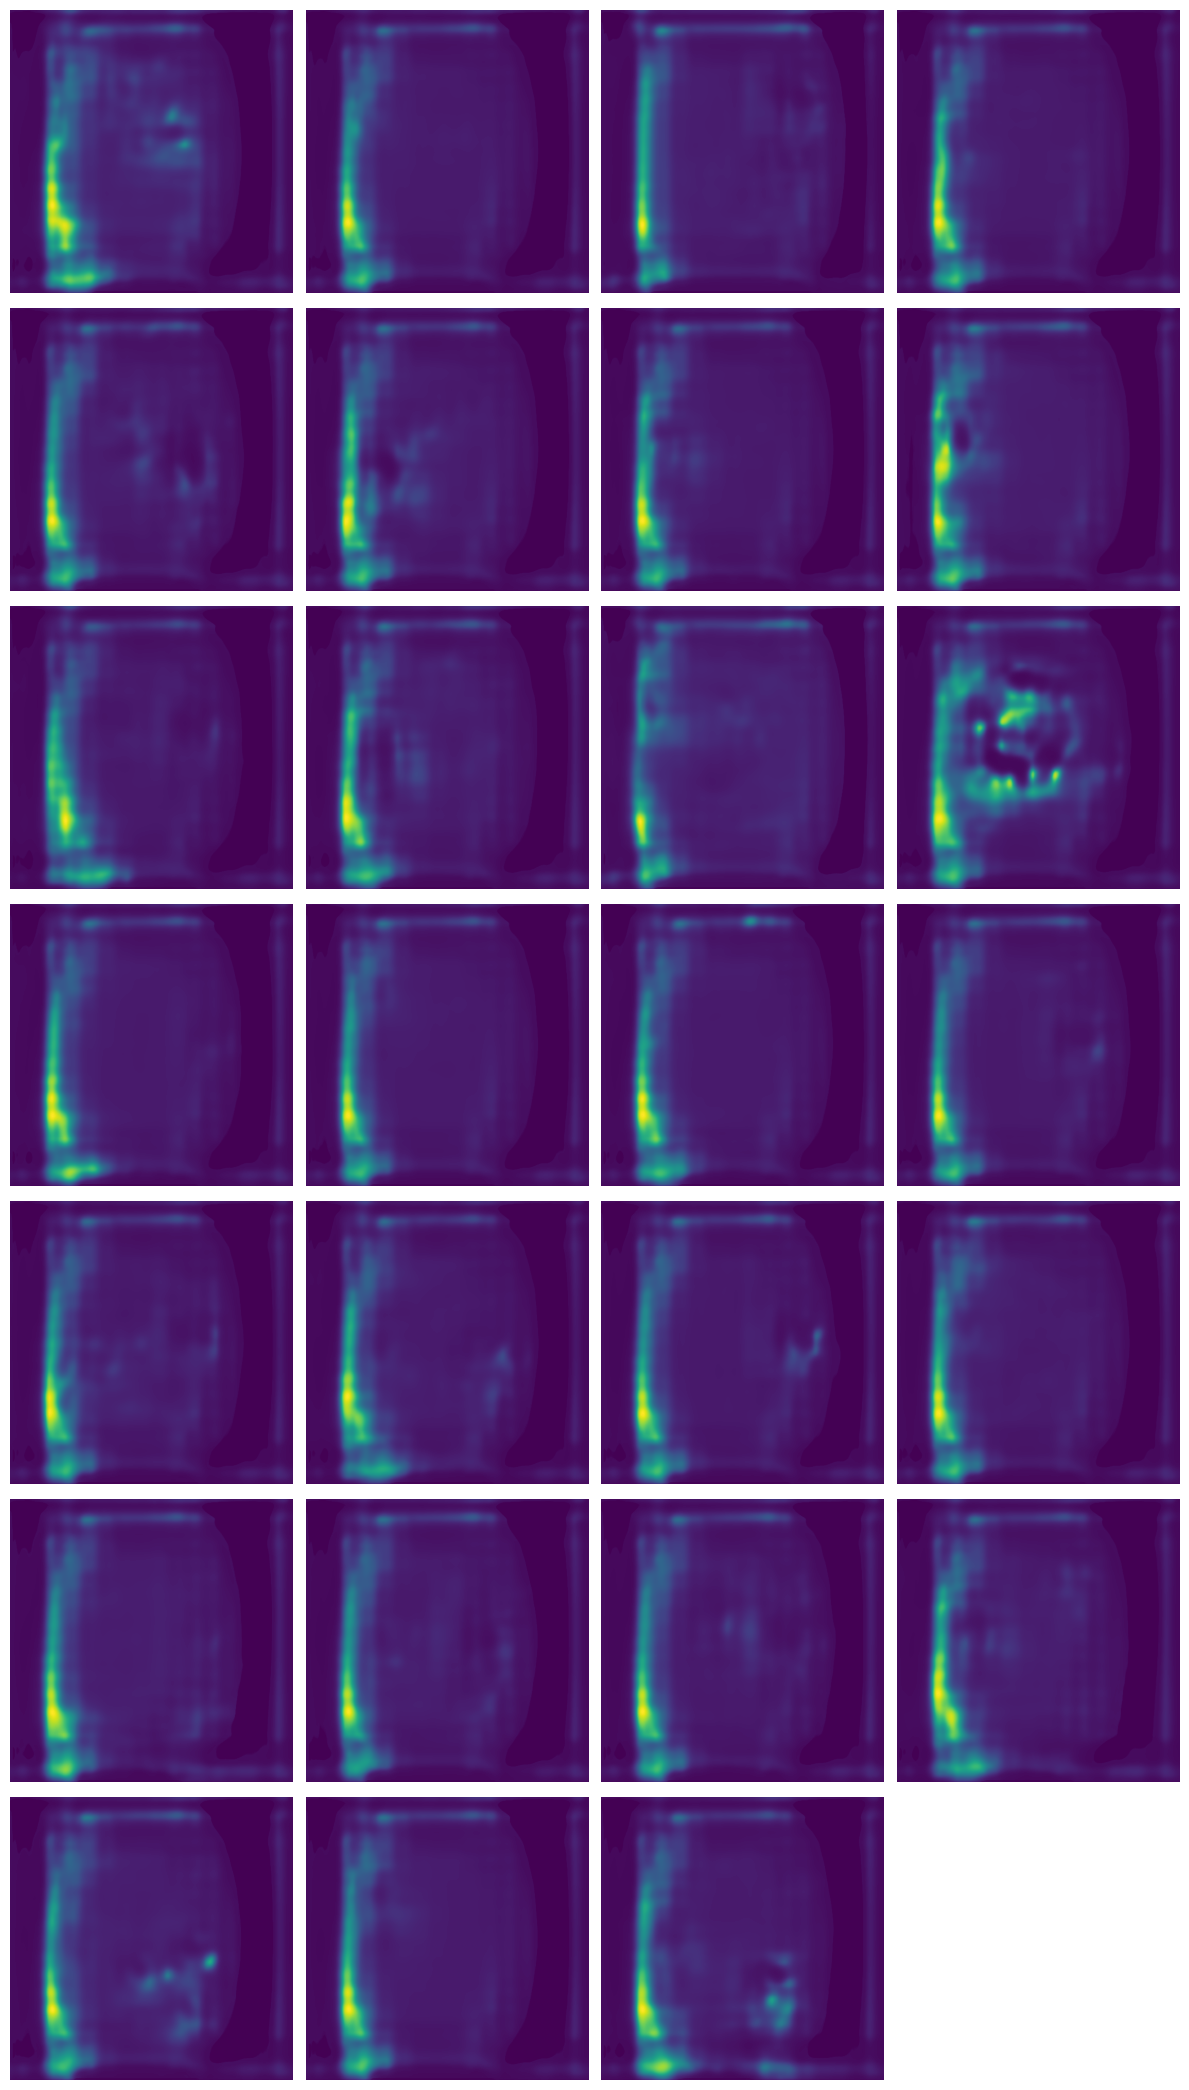

In [28]:
import matplotlib.pyplot as plt

# Assuming val_pred is a NumPy array containing the predicted images

num_images = val_pred.shape[0]  # Get the number of predicted images

# Create a grid of subplots to display the images
rows = int(num_images / 4) + 1
fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))

# Iterate over the predicted images and plot them
for i in range(num_images):
    ax = axes[i // 4, i % 4]
    ax.imshow(val_pred[i])
    ax.axis('off')

# Remove any empty subplots if the number of images is not a multiple of 4
if num_images % 4 != 0:
    for i in range(num_images % 4, 4):
        axes[-1, i].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [29]:
for i in range (val_pred.shape[0]) :
    print(i,np.sum(val_pred[i,:,:,:]))

0 19476.303
1 15382.906
2 14282.326
3 16006.248
4 15917.474
5 16516.219
6 15771.233
7 16657.936
8 19084.346
9 17630.45
10 13532.843
11 24177.064
12 16786.78
13 15177.218
14 16324.687
15 15492.607
16 16894.014
17 18122.541
18 15656.643
19 16133.038
20 16667.123
21 14857.044
22 15910.506
23 18474.668
24 16563.34
25 15280.073
26 18686.406
